In [1]:
ls

 Volume in drive D is DATA
 Volume Serial Number is 1646-E442

 Directory of D:\models\9.CrowdDetection-DroneVision

01/17/2024  03:52 PM    <DIR>          .
01/16/2024  11:04 AM    <DIR>          ..
01/17/2024  09:44 AM    <DIR>          .ipynb_checkpoints
01/17/2024  03:44 PM    <DIR>          .virtual_documents
01/17/2024  11:57 AM         3,038,531 CrowdDetection2.ipynb
01/17/2024  03:52 PM            31,491 CrowdDetection3.ipynb
01/17/2024  03:15 PM    <DIR>          CSRNet-Keras
01/16/2024  02:19 PM       174,398,901 ShanghaiTech_Crowd_Counting_Dataset.zip
11/08/2023  01:01 PM         2,285,239 SIYI AI Tracking Module User Manual v1.0.pdf
11/17/2023  01:03 PM           566,244 군중혼잡도 기술 제안서.hwp
11/03/2023  03:40 PM         2,622,650 다중객체인식 군중혼잡도 탐지.pptx
11/08/2023  04:45 PM       165,187,441 동영상사진자료.zip
               7 File(s)    348,130,497 bytes
               5 Dir(s)  1,470,569,304,064 bytes free


In [24]:
!python --version
!pip --version

Python 3.11.5
pip 23.2.1 from D:\Programs\anaconda3\Lib\site-packages\pip (python 3.11)



In [3]:
cd CSRNet-Keras

D:\models\9.CrowdDetection-DroneVision\CSRNet-Keras


In [4]:
ls

 Volume in drive D is DATA
 Volume Serial Number is 1646-E442

 Directory of D:\models\9.CrowdDetection-DroneVision\CSRNet-Keras

01/17/2024  03:15 PM    <DIR>          .
01/17/2024  03:52 PM    <DIR>          ..
01/16/2024  05:01 PM             1,307 .gitignore
01/17/2024  03:17 PM    <DIR>          __pycache__
01/16/2024  05:01 PM             2,998 CSRNet.py
01/17/2024  10:07 AM    <DIR>          data
01/16/2024  05:01 PM           632,339 generate_datasets.ipynb
01/16/2024  05:01 PM         1,781,675 main.ipynb
01/16/2024  05:01 PM    <DIR>          materials
01/16/2024  05:01 PM    <DIR>          models
01/16/2024  05:01 PM             1,783 README.md
01/17/2024  02:21 PM             2,427 utils_callback.py
01/17/2024  01:37 PM             3,920 utils_gen.py
01/16/2024  05:01 PM             2,778 utils_imgproc.py
01/16/2024  05:01 PM               239 utils_loss.py
01/17/2024  03:15 PM    <DIR>          weights_A
01/16/2024  05:01 PM    <DIR>          weights_A_MSE_bestMAE67.984_Th

## Data generation

In [5]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip --version

pip 23.3.2 from D:\Programs\anaconda3\envs\crowd\lib\site-packages\pip (python 3.10)

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install keras==2.14

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [8]:
import keras
print(keras.__version__)

2.14.0


In [11]:
!pip install h5py==3.9.0
!pip install opencv
!pip install keras
!pip install tensorflow==2.13.0
!pip install scipy
!pip install tqdm
!pip install matplotlib==3.7.4

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [25]:
import h5py
print(h5py.__version__)
import cv2
print(cv2.__version__)
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)
import scipy
print(scipy.__version__)
import tqdm
print(tqdm.__version__)
import matplotlib
print(matplotlib.__version__)

3.9.0
4.9.0
2.14.0
2.13.0
1.11.4
4.66.1
3.7.4


In [10]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils_gen import gen_density_map_gaussian
import matplotlib.pyplot as plt
%matplotlib inline


root = 'data/ShanghaiTech/'
part_A_train = os.path.join(root, 'part_A/train_data', 'images')
part_A_test = os.path.join(root, 'part_A/test_data', 'images')
part_B_train = os.path.join(root, 'part_B/train_data', 'images')
part_B_test = os.path.join(root, 'part_B/test_data', 'images')
path_sets_A = [part_A_train, part_A_test]
path_sets_B = [part_B_train, part_B_test]
img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)
print(len(img_paths_A))
img_paths_B = []
for path in path_sets_B:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_B.append(img_path)
print(len(img_paths_B))

482
716


In [11]:
for dataset in ['A']:
    img_paths = eval('img_paths_'+dataset)
    for img_path in tqdm(img_paths):
        img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
        img = cv2.imread(img_path)
        sigma = 4  if 'part_A' in img_path else 15
        k = np.zeros((img.shape[0], img.shape[1]))
        gt = pts["image_info"][0, 0][0, 0][0]
        for i in range(len(gt)):
            if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1

        DM = gen_density_map_gaussian(k, gt, sigma=sigma)

        file_path = img_path.replace('.jpg', '.h5').replace('images', 'ground')
        with h5py.File(file_path, 'w') as hf:
            hf['density'] = DM

100%|████████████████████████████████████████████████████████████████████████████████| 482/482 [00:51<00:00,  9.40it/s]


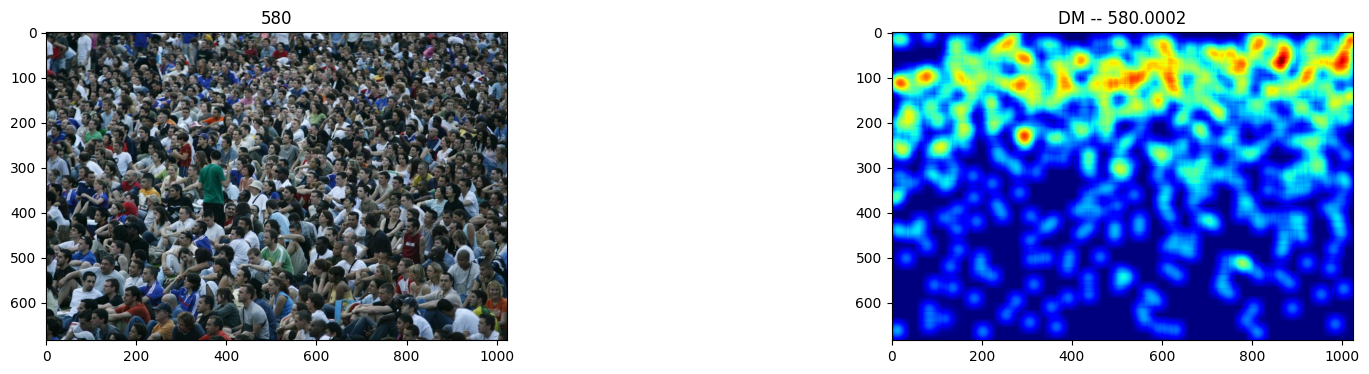

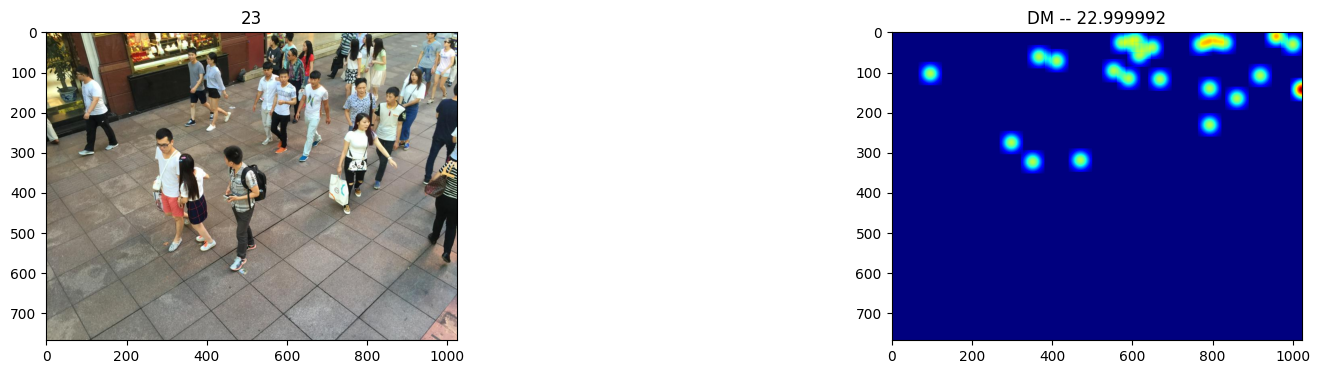

In [12]:
# Show a sample
img_paths = ['data/ShanghaiTech/part_A/train_data/images/IMG_196.jpg',
             'data/ShanghaiTech/part_B/test_data/images/IMG_1.jpg']
for img_path in img_paths:
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)
    
    sigma = 4  if 'part_A' in img_path else 15
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = pts["image_info"][0, 0][0, 0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    DM = gen_density_map_gaussian(k, gt, sigma=sigma)
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(DM), cmap=plt.cm.jet)
    ax1.set_title('DM -- '+str(np.sum(DM)))
    plt.show()

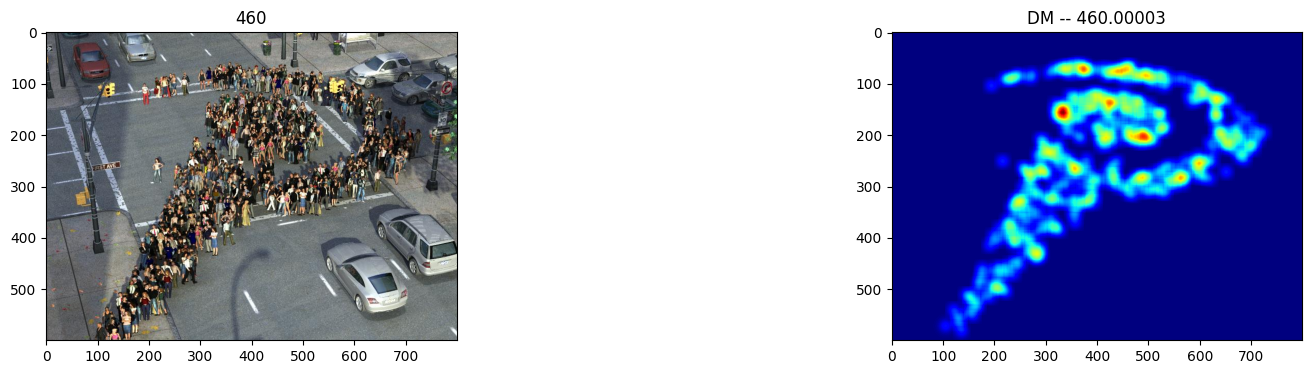

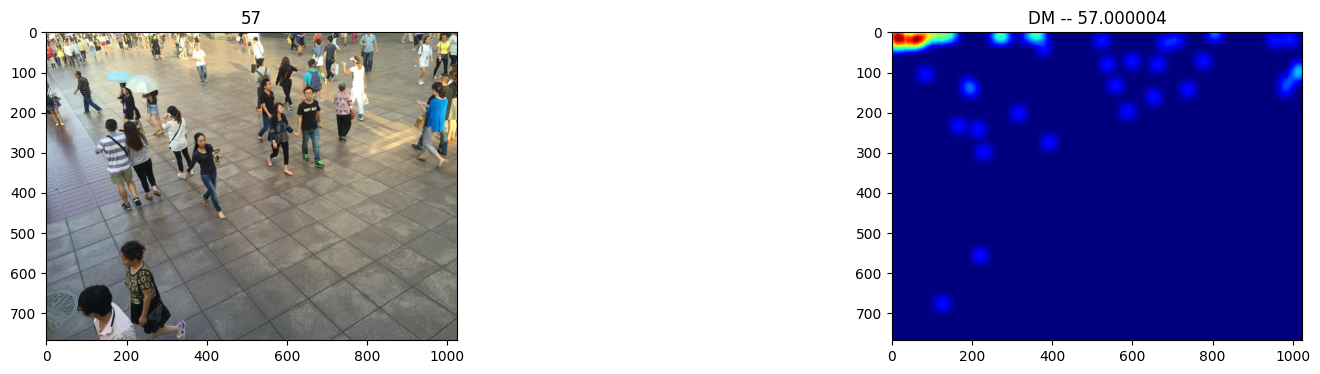

In [13]:
# Show a sample
img_paths = ['data/ShanghaiTech/part_A/train_data/images/IMG_197.jpg',
             'data/ShanghaiTech/part_B/test_data/images/IMG_15.jpg']
for img_path in img_paths:
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)
    
    sigma = 4  if 'part_A' in img_path else 15
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = pts["image_info"][0, 0][0, 0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    DM = gen_density_map_gaussian(k, gt, sigma=sigma)
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(DM), cmap=plt.cm.jet)
    ax1.set_title('DM -- '+str(np.sum(DM)))
    plt.show()

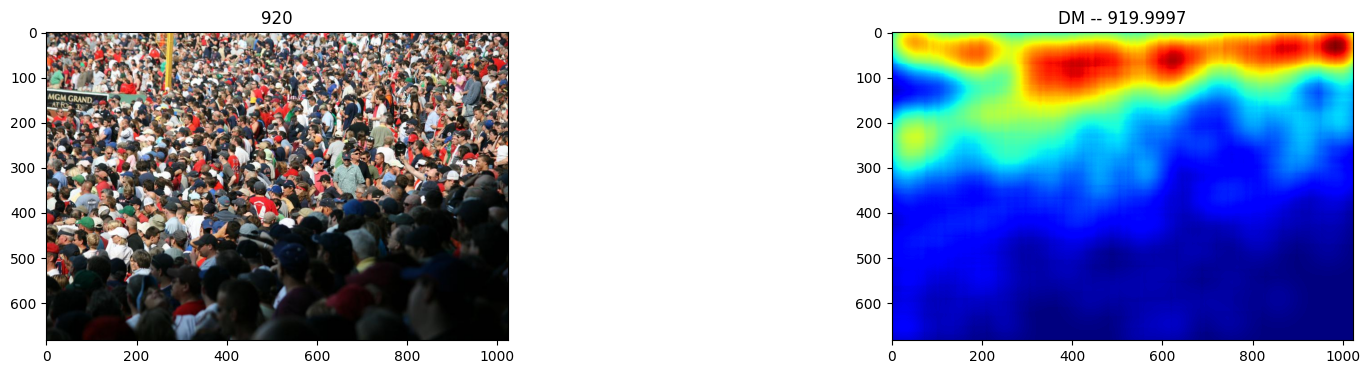

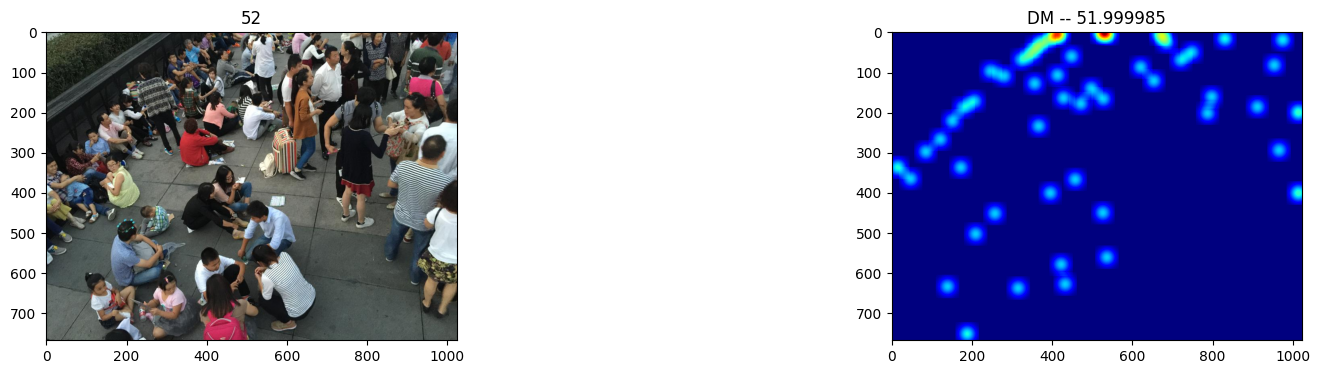

In [14]:
# Show a sample
img_paths = ['data/ShanghaiTech/part_A/train_data/images/IMG_10.jpg',
             'data/ShanghaiTech/part_B/test_data/images/IMG_2.jpg']
for img_path in img_paths:
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)
    
    sigma = 4  if 'part_A' in img_path else 15
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = pts["image_info"][0, 0][0, 0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    DM = gen_density_map_gaussian(k, gt, sigma=sigma)
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(DM), cmap=plt.cm.jet)
    ax1.set_title('DM -- '+str(np.sum(DM)))
    plt.show()

In [ ]:
import os
import cv2
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
from utils_gen import gen_paths_img_dm, gen_var_from_paths
from utils_imgproc import norm_by_imagenet
%matplotlib inline
plt.ioff()


# Settings
net = 'CSRNet'
dataset = "A"
# Generate paths of (train, test) x (img, dm)
(test_img_paths, train_img_paths), (test_dm_paths, train_dm_paths) = gen_paths_img_dm(
    path_file_root='data/paths_train_val_test',
    dataset=dataset
)
# Generate raw images(normalized by imagenet rgb) and density maps
test_x, test_y = gen_var_from_paths(test_img_paths[:], unit_len=None), gen_var_from_paths(test_dm_paths[:], stride=8, unit_len=None)
test_x = norm_by_imagenet(test_x)  # Normalization on raw images in test set, those of training set are in image_preprocessing below.
print('Test data size:', test_x.shape[0], test_y.shape[0], len(test_img_paths))
train_x, train_y = gen_var_from_paths(train_img_paths[:], unit_len=None), gen_var_from_paths(train_dm_paths[:], stride=8, unit_len=None)
print('Train data size:', train_x.shape[0], train_y.shape[0], len(train_img_paths))
# Delete the directory for saving weights during last training.
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)

## Train/Test

In [15]:
pip install numpy==1.22

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy
print(numpy.__version__)

1.22.0


In [17]:
import numpy as np

# This will work
a = [[1, 2, 3], [4, 5, 6]]
np.array(a)

# This will throw the ValueError you're seeing
b = [[1, 2, 3], [4, 5]]
np.array(b)

C:\Users\ubayd\AppData\Local\Temp\ipykernel_37136\648817740.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(b)


array([list([1, 2, 3]), list([4, 5])], dtype=object)

In [19]:
# This will create an array of Python lists
c = np.array(b, dtype=object)

In [20]:
import os
import cv2
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
from utils_gen import gen_paths_img_dm, gen_var_from_paths
from utils_imgproc import norm_by_imagenet
%matplotlib inline
plt.ioff()

# Settings
net = 'CSRNet'
dataset = "A"
# Generate paths of (train, test) x (img, dm)
(test_img_paths, train_img_paths), (test_dm_paths, train_dm_paths) = gen_paths_img_dm(
    path_file_root='data/paths_train_val_test',
    dataset=dataset
)
# Generate raw images(normalized by imagenet rgb) and density maps
test_x, test_y = gen_var_from_paths(test_img_paths[:], unit_len=None), gen_var_from_paths(test_dm_paths[:], stride=8, unit_len=None)
test_x = norm_by_imagenet(test_x)  # Normalization on raw images in test set, those of training set are in image_preprocessing below.
print('Test data size:', test_x.shape[0], test_y.shape[0], len(test_img_paths))
train_x, train_y = gen_var_from_paths(train_img_paths[:], unit_len=None), gen_var_from_paths(train_dm_paths[:], stride=8, unit_len=None)
print('Train data size:', train_x.shape[0], train_y.shape[0], len(train_img_paths))
# Delete the directory for saving weights during last training.
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)

D:\models\9.CrowdDetection-DroneVision\CSRNet-Keras\utils_gen.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(vars)
D:\models\9.CrowdDetection-DroneVision\CSRNet-Keras\utils_imgproc.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(imgs)


Test data size: 182 182 182
Train data size: 300 300 300


In [21]:
from keras.optimizers import Adam
from keras.utils import plot_model
from CSRNet import CSRNet

# Create empty directory for saving weights during training
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)
os.makedirs(weights_dir)

# Settings of network
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
LOSS = 'MSE'
optimizer = Adam(lr=1e-5)

# Create my model
model = CSRNet(input_shape=(None, None, 3))
model.compile(optimizer=optimizer, loss='MSE')
model.summary()
if not os.path.exists('models'):
    os.makedirs('models')
plot_model(model, 'models/{}.png'.format(net))
with open('./models/{}.json'.format(net), 'w') as fout:
    fout.write(model.to_json())

D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 64)    0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   147584    
                                                             

In [36]:
import sys
import pandas as pd
from time import time, ctime
from utils_imgproc import image_preprocessing
from utils_callback import eval_loss, callbacks_during_train


# Settings of training
batch_size = 1
epoch = 250
val_rate = 0.5
val_rate_dec = {'A': [80, 70], 'B': [9, 8.5]}
len_train = train_x.shape[0]
num_iter = int((len_train-0.1) // batch_size + 1)
best_values = {'mae': 1e5, 'rmse': 1e5, 'sfn': 1e5, 'mape': 1e5}
losses = [[1e5, 1e5, 1e5, 1e5]]
# Settings of display
dis_idx = 16 if dataset == 'B' else 0
dis_path = test_img_paths[dis_idx]
dis_x = test_x[dis_idx]
dis_y = test_y[dis_idx]
dis_lim = (5, 35) if dataset == 'B' else (40, 150)
time_st = time()

# Training iterations
for ep in range(epoch):
    for idx_train in range(0, len_train, batch_size):
        dis_epoch = str(ep+1)+'-'+str(idx_train+1)+'_'+str(len_train)
        x, y = train_x[idx_train:idx_train+batch_size], train_y[idx_train:idx_train+batch_size]
        # Preprocessings on raw images
        x, y = image_preprocessing(
            x, y,
            flip_hor=True
        )
        model.fit(x, y, batch_size=1, verbose=0)
        idx_val = (idx_train / batch_size + 1)
        # Eval losses and save models
        if idx_val % (num_iter * val_rate) == 0:
            # To see predictions during training in directory 'tmp'
#             callbacks_during_train(
#                 model, dis_x=dis_x, dis_y=dis_y, dis_path=dis_path,
#                 net=net, epoch=dis_epoch
#             )
            loss = eval_loss(model, test_x, test_y, quality=False)
            if loss[0] < val_rate_dec[dataset][0]:
                val_rate = min(val_rate, 0.25)
            if loss[0] < val_rate_dec[dataset][1]:
                val_rate = min(val_rate, 0.1)
            losses.append(loss)
            if (loss[0] < best_values['mae']) or (loss[0] == best_values['mae'] and loss[1] < best_values['rmse']):
                model.save_weights(os.path.join(weights_dir, '{}_best.hdf5'.format(net)))
            for idx_best in range(len(loss)):
                if loss[idx_best] < best_values[list(best_values.keys())[idx_best]]:
                    best_values[list(best_values.keys())[idx_best]] = loss[idx_best]
                    to_save = True
            if to_save:
                path_save = os.path.join(weights_dir, ''.join([
                    net,
                    '_MAE', str(round(loss[0], 3)), '_RMSE', str(round(loss[1], 3)),
                    '_SFN', str(round(loss[2], 3)), '_MAPE', str(round(loss[3], 3)),
                    '_epoch', str(ep+1), '-', str(idx_val), '.hdf5'
                ]))
                model.save_weights(path_save)
                to_save = False
        # Progress panel
        time_consuming = time() - time_st
        sys.stdout.write('In epoch {}, with MAE-RMSE-SFN-MAPE={}, time consuming={}m-{}s\r'.format(
            dis_epoch, np.round(np.array(losses)[-1, :], 2),
            int(time_consuming/60), int(time_consuming-int(time_consuming/60)*60)
        ))
        sys.stdout.flush()

# Save records
losses = np.array(losses[1:])
pd.DataFrame(losses).to_csv('{}/loss.csv'.format(weights_dir), index=False, header=['MAE', 'RMSE', 'SFN', 'MAPE'])
losses_MAE, losses_RMSE, losses_SFN, losses_MAPE = losses[:, 0], losses[:, 1], losses[:, 2], losses[:, 3]
plt.plot(losses_MAE, 'r')
plt.plot(losses_RMSE, 'b')
multiplier = int(round(dis_lim[0] / (np.min(losses_SFN)+0.1)))
plt.plot(losses_SFN * multiplier, 'g')
plt.legend(['MAE', 'RMSE', 'SFN*{}'.format(multiplier)])
plt.ylim(dis_lim)
plt.title('Val_losses in {} epochs'.format(epoch))
plt.savefig('{}/{}_val_loss.png'.format(weights_dir, net))
plt.show()

# Rename weights_dir by the trainging end time, to prevent the careless deletion or overwriting
end_time_of_train = '-'.join(ctime().split()[:-2])
suffix_new_dir = '_{}_{}_bestMAE{}_{}'.format(dataset, LOSS, str(round(best_values['mae'], 3)), end_time_of_train)
weights_dir_neo = 'weights'+suffix_new_dir
shutil.move('weights_{}'.format(dataset), weights_dir_neo)

InvalidArgumentError: Graph execution error:

Detected at node 'model/conv2d_10/Conv2D/SpaceToBatchND' defined at (most recent call last):
    File "D:\Programs\anaconda3\envs\crowd\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Programs\anaconda3\envs\crowd\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "D:\Programs\anaconda3\envs\crowd\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\Programs\anaconda3\envs\crowd\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\Programs\anaconda3\envs\crowd\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ubayd\AppData\Local\Temp\ipykernel_37136\1392697920.py", line 35, in <module>
      model.fit(x, y, batch_size=1, verbose=0)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\training.py", line 1783, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function
      return step_function(self, iterator)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step
      outputs = model.train_step(data)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
      y_pred = self(x, training=True)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\training.py", line 589, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\functional.py", line 515, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "D:\Programs\anaconda3\envs\crowd\lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d_10/Conv2D/SpaceToBatchND'
padded_shape[0]=93 is not divisible by block_shape[0]=2
	 [[{{node model/conv2d_10/Conv2D/SpaceToBatchND}}]] [Op:__inference_train_function_7263]

In [34]:
import os
import sys
import cv2
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
import tensorflow as tf
from utils_imgproc import image_preprocessing
from utils_callback import eval_loss, callbacks_during_train
from utils_gen import gen_paths_img_dm, gen_var_from_paths
from utils_imgproc import norm_by_imagenet
%matplotlib inline
plt.ioff()

# Assuming spatial dimensions are (height, width, channels)
height = x.shape[1]
width = x.shape[2]

# Decide on block shape
block_height = 64
block_width = 64
block_shape = [block_height, block_width]

# Calculate paddings
pad_top = (block_height - (height % block_height)) % block_height
pad_bottom = pad_top
pad_left = (block_width - (width % block_width)) % block_width
pad_right = pad_left

# Settings of training
batch_size = 1
epoch = 250
val_rate = 0.5
val_rate_dec = {'A': [80, 70], 'B': [9, 8.5]}
len_train = train_x.shape[0]
num_iter = int((len_train-0.1) // batch_size + 1)
best_values = {'mae': 1e5, 'rmse': 1e5, 'sfn': 1e5, 'mape': 1e5}
losses = [[1e5, 1e5, 1e5, 1e5]]
# Settings of display
dis_idx = 16 if dataset == 'B' else 0
dis_path = test_img_paths[dis_idx]
dis_x = test_x[dis_idx]
dis_y = test_y[dis_idx]
dis_lim = (5, 35) if dataset == 'B' else (40, 150)
time_st = time.time()

# Training iterations
for ep in range(epoch):
    for idx_train in range(0, len_train, batch_size):
        dis_epoch = str(ep+1)+'-'+str(idx_train+1)+'_'+str(len_train)
        x, y = train_x[idx_train:idx_train+batch_size], train_y[idx_train:idx_train+batch_size]
        # Preprocessings on raw images
        x, y = image_preprocessing(
            x, y,
            flip_hor=True
        )

        # Apply SpaceToBatchND
        x = tf.nn.space_to_batch(x, block_shape=block_shape, paddings = [[0, 0], [0, 0], [pad_top, pad_bottom], [pad_left, pad_right]])

        model.fit(x, y, batch_size=1, verbose=0)
        idx_val = (idx_train / batch_size + 1)
        # Eval losses and save models
        if idx_val % (num_iter * val_rate) == 0:
            # To see predictions during training in directory 'tmp'
            # callbacks_during_train(
            #     model, dis_x=dis_x, dis_y=dis_y, dis_path=dis_path,
            #     net=net, epoch=dis_epoch
            # )
            loss = eval_loss(model, test_x, test_y, quality=False)
            if loss[0] < val_rate_dec[dataset][0]:
                val_rate = min(val_rate, 0.25)
            if loss[0] < val_rate_dec[dataset][1]:
                val_rate = min(val_rate, 0.1)
            losses.append(loss)
            if (loss[0] < best_values['mae']) or (loss[0] == best_values['mae'] and loss[1] < best_values['rmse']):
                model.save_weights(os.path.join(weights_dir, '{}_best.hdf5'.format(net)))
            for idx_best in range(len(loss)):
                if loss[idx_best] < best_values[list(best_values.keys())[idx_best]]:
                    best_values[list(best_values.keys())[idx_best]] = loss[idx_best]
                    to_save = True
            if to_save:
                path_save = os.path.join(weights_dir, ''.join([
                    net,
                    '_MAE', str(round(loss[0], 3)), '_RMSE', str(round(loss[1], 3)),
                    '_SFN', str(round(loss[2], 3)), '_MAPE', str(round(loss[3], 3)),
                    '_epoch', str(ep+1), '-', str(idx_val), '.hdf5'
                ]))
                model.save_weights(path_save)
                to_save = False
        # Progress panel
        time_consuming = time() - time_st
        sys.stdout.write('In epoch {}, with MAE-RMSE-SFN-MAPE={}, time consuming={}m-{}s\r'.format(
            dis_epoch, np.round(np.array(losses)[-1, :], 2),
            int(time_consuming/60), int(time_consuming-int(time_consuming/60)*60)
        ))
        sys.stdout.flush()

# Save records
losses = np.array(losses[1:])
pd.DataFrame(losses).to_csv('{}/loss.csv'.format(weights_dir), index=False, header=['MAE', 'RMSE', 'SFN', 'MAPE'])
losses_MAE, losses_RMSE, losses_SFN, losses_MAPE = losses[:, 0], losses[:, 1], losses[:, 2], losses[:, 3]
plt.plot(losses_MAE, 'r')
plt.plot(losses_RMSE, 'b')
multiplier = int(round(dis_lim[0] / (np.min(losses_SFN)+0.1)))
plt.plot(losses_SFN * multiplier, 'g')
plt.legend(['MAE', 'RMSE', 'SFN*{}'.format(multiplier)])
plt.ylim(dis_lim)
plt.title('Val_losses in {} epochs'.format(epoch))
plt.savefig('{}/{}_val_loss.png'.format(weights_dir, net))
plt.show()

# Rename weights_dir by the training end time, to prevent the careless deletion or overwriting
end_time_of_train = '-'


InvalidArgumentError: {{function_node __wrapped__SpaceToBatchND_device_/job:localhost/replica:0/task:0/device:CPU:0}} paddings should have shape [2, 2] instead of [4,2] [Op:SpaceToBatchND]